<a href="https://colab.research.google.com/github/AyushMaria/Vortex-Detection/blob/main/YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
from google.colab import drive
import numpy as np
import time
import sys
import os
import pickle

In [2]:
# Mount the Google Drive at mount
mount='/content/gdrive'
drive.mount(mount, force_remount=True)
# Switch to the directory on the Google Drive that you want to use
drive_root=mount + '/My Drive/Colab Notebooks/Object Detection'

Mounted at /content/gdrive


In [4]:
%cd $drive_root
%pwd

/content/gdrive/My Drive/Colab Notebooks/Object Detection


'/content/gdrive/My Drive/Colab Notebooks/Object Detection'

In [7]:
CONFIDENCE = 0.5
SCORE_THRESHOLD = 0.5
IOU_THRESHOLD = 0.5

# the neural network configuration
config_path = "cfg/yolov3.cfg"
# the YOLO net weights file
with open('weights/data.pkl', 'rb') as f:
    weights_path = pickle.load(f)
    f.close()

# weights_path = "weights/yolov3-tiny.weights"

# loading all the class labels (objects)
labels = open("data/file0.txt").read().strip().split("\n")
# generating colors for each object for later plotting
colors = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")

UnpicklingError: ignored

In [ ]:
# load the YOLO network
net = cv2.dnn.readNetFromDarknet(config_path, weights_path)

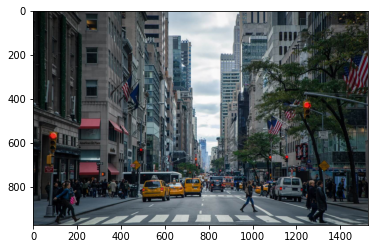

In [ ]:
import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow
%matplotlib inline


path_name = "Images/file0.png"
image = mpimg.imread(path_name, cv2.IMREAD_UNCHANGED)

imshow(image)
file_name = os.path.basename(path_name)
filename, ext = file_name.split(".")

In [ ]:
print(image.shape)
h, w = image.shape[:2]
# create 4D blob
blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)

(975, 1526, 3)


In [ ]:
print("image.shape:", image.shape)
print("blob.shape:", blob.shape)

image.shape: (975, 1526, 3)
blob.shape: (1, 3, 416, 416)


In [ ]:
# sets the blob as the input of the network
net.setInput(blob)
# get all the layer names
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
# feed forward (inference) and get the network output
# measure how much it took in seconds
start = time.perf_counter()
layer_outputs = net.forward(ln)
time_took = time.perf_counter() - start
print(f"Time took: {time_took:.2f}s")

Time took: 2.33s


In [ ]:
font_scale = 1
thickness = 1
boxes, confidences, class_ids = [], [], []
# loop over each of the layer outputs
for output in layer_outputs:
    # loop over each of the object detections
    for detection in output:
        # extract the class id (label) and confidence (as a probability) of
        # the current object detection
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        # discard out weak predictions by ensuring the detected
        # probability is greater than the minimum probability
        if confidence > CONFIDENCE:
            # scale the bounding box coordinates back relative to the
            # size of the image, keeping in mind that YOLO actually
            # returns the center (x, y)-coordinates of the bounding
            # box followed by the boxes' width and height
            box = detection[:4] * np.array([w, h, w, h])
            (centerX, centerY, width, height) = box.astype("int")
            # use the center (x, y)-coordinates to derive the top and
            # and left corner of the bounding box
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            # update our list of bounding box coordinates, confidences,
            # and class IDs
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            class_ids.append(class_id)

In [ ]:
print(detection.shape)

(85,)


In [ ]:
# loop over the indexes we are keeping
for i in range(len(boxes)):
    # extract the bounding box coordinates
    x, y = boxes[i][0], boxes[i][1]
    w, h = boxes[i][2], boxes[i][3]
    # draw a bounding box rectangle and label on the image
    color = [int(c) for c in colors[class_ids[i]]]
    cv2.rectangle(image, (x, y), (x + w, y + h), color=color, thickness=thickness)
    text = f"{labels[class_ids[i]]}: {confidences[i]:.2f}"
    # calculate text width & height to draw the transparent boxes as background of the text
    (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, fontScale=font_scale, thickness=thickness)[0]
    text_offset_x = x
    text_offset_y = y - 5
    box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height))
    overlay = image.copy()
    cv2.rectangle(overlay, box_coords[0], box_coords[1], color=color, thickness=cv2.FILLED)
    # add opacity (transparency to the box)
    image = cv2.addWeighted(overlay, 0.6, image, 0.4, 0)
    # now put the text (label: confidence %)
    cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=font_scale, color=(0, 0, 0), thickness=thickness)

In [ ]:
cv2.imwrite(filename + "_yolo3." + ext, image)

True